In [19]:
import pandas as pd
import numpy as np
import os

import networkx as nx
import matplotlib.pyplot as plt

In [20]:

DATA_PATH = 'data/wikispeedia_paths-and-graph/'

# load tsv files into pandas dataframes
articles = pd.read_csv(os.path.join(DATA_PATH, 'articles.tsv'), sep='\t', comment='#', names=['article'])
categories = pd.read_csv(os.path.join(DATA_PATH, 'categories.tsv'), sep='\t', comment='#', names=['article', 'category'])
links = pd.read_csv(os.path.join(DATA_PATH, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
path_finished = pd.read_csv(os.path.join(DATA_PATH, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(os.path.join(DATA_PATH, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])


In [21]:
# compare results with load function
from src.scripts.loading_data import *

article, link = loading_articles_links('2007', raw = True)


In [22]:
categories_cleaned = categories.copy(deep=True)
categories_cleaned.category = categories_cleaned.category.str.split('.')
# remove "subject" (starts by this everywhere)
categories_cleaned.category = categories_cleaned.category.apply(lambda x: x[1:])
categories_cleaned['main_category'] = categories_cleaned.category.apply(lambda x: x[0])


display(categories_cleaned.category.apply(lambda x: x[0]).value_counts())

len(categories_cleaned.article.unique())

category
Science                    1122
Geography                  1084
People                      689
History                     545
Everyday_life               374
Design_and_Technology       254
Countries                   229
Citizenship                 224
Language_and_literature     196
Religion                    134
Music                        97
Business_Studies             88
IT                           85
Mathematics                  45
Art                          38
Name: count, dtype: int64

4598

### Problem: a same article can belong to several identical categories.

Let's isolate all these problematic articles.

In [23]:
categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]
categories_duplicates

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


First, we can also notice that some article are in the same main categories but in different subcategories. Let's focus on the main categories, we can then remove the duplicates of these articles.

In [24]:

# Remove one row if two rows have the same main category and article name. 

main_cat = categories_duplicates['main_category'].unique()
indices_to_drop = categories_duplicates.loc[categories_duplicates.duplicated(subset=['article', 'main_category'])].index
print(indices_to_drop)
categories_cleaned = categories_cleaned.drop(indices_to_drop)

categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]
categories_duplicates

# people_people = categories_duplicates.loc[categories_duplicates.category.map(lambda x: x[0]=='People')]
# people_other = categories_duplicates.loc[categories_duplicates.article.isin(people_people.article)]
# people_other = people_other.loc[people_other.category.map(lambda x: x[0]=='People')]
# categories_cleaned = categories_cleaned.drop(people_other.index)

# categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]
# categories_duplicates

Index([ 178,  206,  298,  308,  425,  585,  589,  621,  625,  753,  839, 1024,
       1058, 1155, 1185, 1199, 1247, 1249, 1333, 1464, 1492, 1497, 1632, 1726,
       1731, 1744, 1761, 1763, 1826, 1838, 1912, 1944, 1986, 1988, 2164, 2252,
       2282, 2287, 2351, 2371, 2408, 2503, 2515, 2647, 2712, 2765, 2834, 2838,
       2939, 3018, 3051, 3058, 3212, 3222, 3303, 3370, 3385, 3387, 3451, 3476,
       3669, 3691, 3698, 3728, 3759, 3881, 3971, 3975, 4035, 4111, 4113, 4144,
       4190, 4249, 4251, 4294, 4315, 4381, 4393, 4421, 4464, 4599, 4613, 4622,
       4635, 4659, 4677, 4720, 4751, 4832, 4834, 4844, 4925, 4981, 5010, 5015,
       5046, 5052, 5069],
      dtype='int64')


,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


Then, let's define a partial ordering between categories based on fully arbitrary decisions. For example, we consider that historical figures should belong to the 'History' category rather than the 'People' category. We do it manually by looking at examples of each cases and deciding of an ordering.

In [25]:

# main_categoryegoryegoryegory = ['History', 'Countries', 'Business_Studies', 'Science', 'Music', 'IT', 'Language_and_literature', 'Mathematics', 'Religion', 'Art']
# sec_cat = ['People', 'Geography', 'Everyday_life', 'Design_and_Technology', 'Citizenship']

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'), ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('History', 'Design_and_Technology'), ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('History', 'Geography'), ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'), ('Science', 'Citizenship'), ('Business_Studies', 'IT'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'), ('Citizenship', 'Everyday_life'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('Science', 'IT'), ('Geography', 'Everyday_life'), ('Geography', 'Science'), ('Business_Studies', 'History'), ('History', 'Citizenship'), ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'), ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'), ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

In [26]:


for cat, subcat in relationships:
    # categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]
    categories_duplicates = categories_cleaned.loc[categories_cleaned.article.duplicated(keep=False)]
    art = categories_duplicates.article.loc[categories_duplicates.main_category==cat].values
    # display(art)
    categories_cleaned = categories_cleaned.drop(index=categories_duplicates.loc[(categories_duplicates.article.isin(art)) & (categories_duplicates.main_category==subcat)].index)
    # display(categories_duplicates.loc[(categories_duplicates.article.isin(art)) & (categories_duplicates.main_category==subcat)])
    # break

categories_duplicates = categories_cleaned.loc[categories_cleaned.article.duplicated(keep=False)]
categories_duplicates

print(categories_cleaned.article.unique().size, categories_cleaned.article.size)

4598 4598


In [27]:
## TODO:: commenter

for cat, subcat in relationships:
    categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]

    main_cat_el = categories_duplicates.loc[categories_duplicates.category.map(lambda x: x[0]==cat)]
    # people_history
    duplicates_from_main_cat = categories_duplicates.loc[categories_duplicates.article.isin(main_cat_el.article)]
    duplicates_from_main_cat = duplicates_from_main_cat.loc[duplicates_from_main_cat.category.map(lambda x: x[0]==subcat)]
    # duplicates_from_main_cat

    # drop the entries starting not with 'History' for articles in 'People' and 'History' main categories 
    categories_cleaned = categories_cleaned.drop(duplicates_from_main_cat.index)

categories_duplicates = categories_cleaned[categories_cleaned.article.map(categories_cleaned.article.value_counts()).gt(1)]
categories_duplicates

print(categories_cleaned.article.unique().size, categories_cleaned.article.size)

4598 4598


And there we go, one category per article. Now we can do nice plots to explore the categories of finished and unfinished paths.

In [28]:
categories_cleaned['main_category'] = categories_cleaned.category.map(lambda x: x[0])
categories_cleaned = categories_cleaned.set_index('article', drop=True)

# Let's cook data for a nice Sankey diagram (plot online)

In [29]:
categories_cleaned

articles = pd.read_csv(os.path.join(DATA_PATH, 'articles.tsv'), sep='\t', comment='#', names=['article'])

path_finished = pd.read_csv(os.path.join(DATA_PATH, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(os.path.join(DATA_PATH, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

test = path_unfinished.target.isin(categories.article)
path_unfinished.target[np.where(~test)[0]].unique()


array(['Long_peper', 'Pikachu', 'Test', 'Adolph_Hitler', 'Netbook',
       'Podcast', 'Christmas', 'Sportacus', 'Charlottes_web', 'C++',
       'Macedonia', 'Usa', '_Zebra', 'Rss', 'Black_ops_2',
       'Western_Australia', 'The_Rock', 'Great', 'Georgia', 'English',
       'Fats', 'Mustard', 'Bogota', 'The', 'Rat', 'Kashmir'], dtype=object)

Oh oh... It seems that some articles are not present in `categories.tsv`... let's kick them out!

In [30]:

path_finished = pd.read_csv(os.path.join(DATA_PATH, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(os.path.join(DATA_PATH, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])


def clean_path(df, finished, verbose=True):
    def find_suitable_end(x):
        '''
            Return the last article in the path that is not a way back denoted by '<'.
        '''
        i=1
        while x[-i]=='<':
            i+=1
        return x[-i]

    init_rows = df.shape[0]
    # drop broken path (NaN)
    df = df.dropna(subset='path')
    # convert path in list of str
    df['path'] = df.path.str.split(';')

    # create new columns for the start and last visited article 
    df['start'] = df.path.map(lambda x: x[0])
    df['end'] = df.path.map(find_suitable_end)

    # articles not present in categories.tsv: we kick them out for our analysis
    not_in_cat = ['Pikachu', 'Christmas', 'Charlottes_web', 'Rat', 'Podcast', 'The',
       'Bogota', 'Sportacus', 'Kashmir', 'Black_ops_2', 'Test',
       'Western_Australia', 'The_Rock', 'Great', 'Adolph_Hitler', 'Macedonia',
       'Usa', 'C++', 'Rss', '_Zebra', 'English', 'Long_peper', 'Mustard',
       'Fats', 'Netbook', 'Georgia']
    df = df.drop(df[df.start.isin(not_in_cat)].index)
    df = df.drop(df[df.end.isin(not_in_cat)].index)
    # for unfinished path, have also to check for the target columns
    if not finished:
        df = df.drop(df[df.target.isin(not_in_cat)].index)    

    if verbose:
        # let's check how much data has been discarded
        print(f'Initial number of rows: {init_rows}, current number of rows: {df.shape[0]}, percentage of loss: {(init_rows-df.shape[0])/init_rows*100:.2f}%')
    return df

path_finished = clean_path(path_finished, True)
path_unfinished = clean_path(path_unfinished, False)

Initial number of rows: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows: 24875, current number of rows: 24802, percentage of loss: 0.29%


Oof, we are not loosing much data, we can consider this correction as negligble. Let's get the data for the sankey plot. 

In [ ]:
import plotly.graph_objects as go


def get_sankey_data(df, finished=True, filename='sankey_data_', df_cat=categories_cleaned):
    df['source_cat'] = df_cat.main_category.loc[df.start].values
    
    if finished:
        df['target_cat'] = df_cat.main_category.loc[df.end].values
    else:
        df['target_cat'] = df_cat.main_category.loc[df.target].values

    grouped_by_cat = df.groupby(['source_cat', 'target_cat'])

    cat = list(df_cat.category.apply(lambda x: x[0]).value_counts().sort_index().index)

    source = []
    target = []
    value = []
    for (scat, ecat), group in grouped_by_cat:
        source.append(scat)
        target.append(ecat)
        value.append(len(group))
    sankey_data_finished = pd.DataFrame(zip(source, target, value), columns=['source', 'target', 'val'])
    sankey_data_finished.to_csv('./data/sankey/'+filename, index=False)
    return df, np.array(value)/sum(value), sum(value)

path_finished, val_finished, _ = get_sankey_data(path_finished, True, 'sankey_data_finished_v1.csv')
path_unfinished, val_unfinished, _ = get_sankey_data(path_unfinished, False, 'sankey_data_unfinished_v1.csv')


For the diagram of finished paths: https://public.flourish.studio/visualisation/20275972/
For the diagram of unfinished paths: https://public.flourish.studio/visualisation/20275435/


Are the distributions of categories the same?

In [32]:

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import bartlett
# predictor: categorical, 2 of them: start and end
# outcome: continuous (in N)
# ==> anova

f_oneway(val_finished, val_unfinished)
# p-value = 1 >>>> 0.05 ==> can't say it's different 

F_onewayResult(statistic=6.142924559647254e-33, pvalue=1.0)

We can not say that the distribution of categories are different.

Some paths are really short: it seems like the player didn't even try to play... Let's remove the paths with a length smaller or equal to 3 (i.e. the player clicked on 2 links at most). Does it change something? 

In [33]:
path_unfinished_trunc = path_unfinished.copy(deep=True)
path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=4)]
path_unfinished_trunc

path_unfinished_trunc, val_unfinished_trunc, _ = get_sankey_data(path_unfinished_trunc, False, 'sankey_data_unfinished_trunc_v1.csv')

For the diagram of unfinished paths longer than 3: https://public.flourish.studio/visualisation/20279232/

We got rid of roughly 10 000 paths! 

In [34]:
f_oneway(val_finished, val_unfinished_trunc)

F_onewayResult(statistic=0.005755658970310895, pvalue=0.9395599083037084)

But we can still not say that the distribution is different... what if we take a higher threshold to count an unfinished path as a proper game? 

In [35]:

for i in range(2, 20):
    path_unfinished_trunc = path_unfinished.copy(deep=True)
    path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=i)]
    
    path_unfinished_trunc, val_unfinished_trunc, sumval = get_sankey_data(path_unfinished_trunc, False, f'sankey_data_unfinished_trunc_{i}_v1.csv')

    stat, pval_anova = f_oneway(val_finished, val_unfinished_trunc)
    stat, pval = ttest_ind(val_finished, val_unfinished_trunc)
    
    print(f'i={i}, number of rows kept:{path_unfinished_trunc.shape[0]}, percentage of rows kept:{100-(path_unfinished.shape[0]-path_unfinished_trunc.shape[0])/path_unfinished.shape[0]*100:.2f}%, pval anova={pval_anova:.3f}, pval ttest={pval:.3f}')

i=2, number of rows kept:19607, percentage of rows kept:79.05%, pval anova=1.000, pval ttest=1.000
i=3, number of rows kept:16390, percentage of rows kept:66.08%, pval anova=0.980, pval ttest=0.980
i=4, number of rows kept:13234, percentage of rows kept:53.36%, pval anova=0.940, pval ttest=0.940
i=5, number of rows kept:10514, percentage of rows kept:42.39%, pval anova=0.878, pval ttest=0.878
i=6, number of rows kept:8060, percentage of rows kept:32.50%, pval anova=0.794, pval ttest=0.794
i=7, number of rows kept:6280, percentage of rows kept:25.32%, pval anova=0.772, pval ttest=0.772
i=8, number of rows kept:4849, percentage of rows kept:19.55%, pval anova=0.688, pval ttest=0.688
i=9, number of rows kept:3893, percentage of rows kept:15.70%, pval anova=0.627, pval ttest=0.627
i=10, number of rows kept:3099, percentage of rows kept:12.49%, pval anova=0.476, pval ttest=0.476
i=11, number of rows kept:2520, percentage of rows kept:10.16%, pval anova=0.385, pval ttest=0.385
i=12, number o

Mmm, the pvalue is below the level of significiance of 0.05 only for paths longer than 15 articles, i.e. when the player clicked on at least 13 links. Considering these long paths only reduces considerably the percentages of data considered, making the sample too small to be significantly relevant. Thus, we can conclude quite safely that the category of the start and target articles is not the main reason behind withdraw.

# Is there games where nobody succeed?

Let's compare unfinished and finished paths with same target and beginning to check if some games lead to more withdraw than others.

In [36]:
path_finished_reduced = path_finished[['start', 'end', 'path', 'rating']].copy(deep=True).set_index(['start', 'end'], drop=True)
path_unfinished_reduced = path_unfinished[['start', 'target', 'path', 'end']].copy(deep=True).set_index(['start', 'target'], drop=True)
# Let's ignore unfinished paths where players clicked less than 2 links: we considered that these players where not serious.
path_unfinished_reduced = path_unfinished_reduced[path_unfinished_reduced.path.str.len()>2]

## Let's compute statistics about the players paths:
# finished:
stats_finished = pd.DataFrame(path_finished_reduced.index.value_counts().sort_index())
stats_finished.index.names = ['start', 'target']
stats_finished['avg_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).mean()
stats_finished['std_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).std()
stats_finished['med_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).median()

# unfinished:
stats_unfinished = pd.DataFrame(path_unfinished_reduced.index.value_counts().sort_index())
stats_unfinished['avg_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).mean()
stats_unfinished['std_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).std()
stats_unfinished['med_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).median()


# Let's merge all these datas
stats_games = stats_finished.join(stats_unfinished, how='inner', lsuffix='_f', rsuffix='_unf').dropna().rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})

stats_games['finished'] = stats_games['finished'].astype(int)
stats_games['unfinished'] = stats_games['unfinished'].astype(int)
stats_games['tot_games_played'] = stats_games['finished']+stats_games['unfinished']
stats_games['percentage_success'] = stats_games['finished']/(stats_games['finished']+stats_games['unfinished'])*100

tot_success_rate = stats_games['finished'].sum()/(stats_games['finished'].sum()+stats_games['unfinished'].sum())*100
tot_success_rate
print(f'Success rate for a random game: {tot_success_rate:.2f}%')

display(stats_games.describe())

display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].min()])
display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].max()])

stats_games


Success rate for a random game: 63.97%


,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,15.314050,9.097014,3.938667,8.325413,8.626033,6.452712,2.939934,6.100207,23.940083,60.287713
std,84.156247,4.881033,5.190165,4.611848,54.833822,3.398554,3.365791,3.377213,137.058807,14.565429
min,2.000000,2.000000,0.000000,2.000000,2.000000,3.000000,0.000000,3.000000,4.000000,15.384615
25%,2.000000,6.333333,1.414214,6.000000,2.000000,4.500000,0.707107,4.000000,5.000000,50.000000
50%,4.000000,7.732143,2.516611,7.000000,2.000000,5.500000,2.121320,5.000000,6.000000,60.000000
75%,7.000000,10.000000,4.327393,9.000000,3.000000,7.500000,4.009331,7.000000,10.000000,71.428571
max,1043.000000,50.500000,64.346717,50.500000,740.000000,35.000000,36.769553,35.000000,1625.000000,93.750000


,,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,
Thailand,Pigeon,2,13.5,3.535534,13.5,11,8.363636,3.139195,8.0,13,15.384615


,,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,
Africa,England,30,4.333333,1.028334,4.0,2,5.0,0.0,5.0,32,93.75


finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  
start               target                       

Let's look at the shortest path and the success percentage of games to determine if there is a link.

In [37]:
# First, we create a graph.
article_names_2007 = pd.read_csv('data/2007/articles.tsv', sep='\t', comment='#', names=['article_2007'])
original_links2007 = pd.read_csv('data/2007/links.tsv', sep='\t', comment='#', names=['linkSource', 'linkTarget'])

G_2007 = nx.DiGraph()
G_2007.add_nodes_from(np.unique(article_names_2007))
G_2007.add_edges_from(original_links2007.to_numpy())

In [38]:
stats_games['links_to_target'] = stats_games.index.map(lambda x: original_links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count().loc[x[1]].values[0])
stats_games['log_links_to_target'] = np.log(stats_games['links_to_target'])
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  \
start               target                      

In [39]:
stats_games['shortest_path'] = stats_games.apply(lambda x: len(nx.shortest_path(G_2007, source=x.name[0], target=x.name[1])), axis=1)
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  \
start               target                      

Let's analyze further these big games

In [55]:
num_games = 20
stats_big_games = stats_games.copy(deep=True).loc[stats_games['tot_games_played']>=num_games].sort_values(by='avg_f_path')
stats_big_games.describe()


,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success,links_to_target,log_links_to_target,shortest_path
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,106.000000,6.889422,2.943896,6.057692,57.403846,5.957286,3.416851,5.105769,163.403846,74.310175,88.346154,3.916896,3.865385
std,240.011356,1.690226,1.680472,1.470807,160.440602,1.485560,2.177111,1.429166,394.445317,15.452300,124.149954,1.076815,0.686818
min,7.000000,2.550000,0.730477,2.000000,2.000000,3.933333,0.000000,3.000000,20.000000,26.923077,3.000000,1.098612,2.000000
25%,21.000000,5.677220,1.857408,5.000000,5.000000,4.879167,1.721641,4.000000,27.750000,65.253177,22.750000,3.124381,3.000000
50%,29.500000,7.000000,2.798235,6.000000,10.000000,5.630682,2.824739,5.000000,38.500000,76.643357,48.000000,3.870332,4.000000
75%,48.500000,8.208848,3.619003,7.000000,20.000000,6.563725,4.470478,5.125000,67.250000,87.152778,109.000000,4.691348,4.000000
max,1043.000000,10.588235,10.531012,10.000000,740.000000,10.750000,10.307764,9.500000,1625.000000,93.750000,751.000000,6.621406,5.000000


/tmp/ipykernel_135711/1674916156.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+1.5+1], 'r--')
/tmp/ipykernel_135711/1674916156.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+1.5+1], 'r--', label='Shortest path')


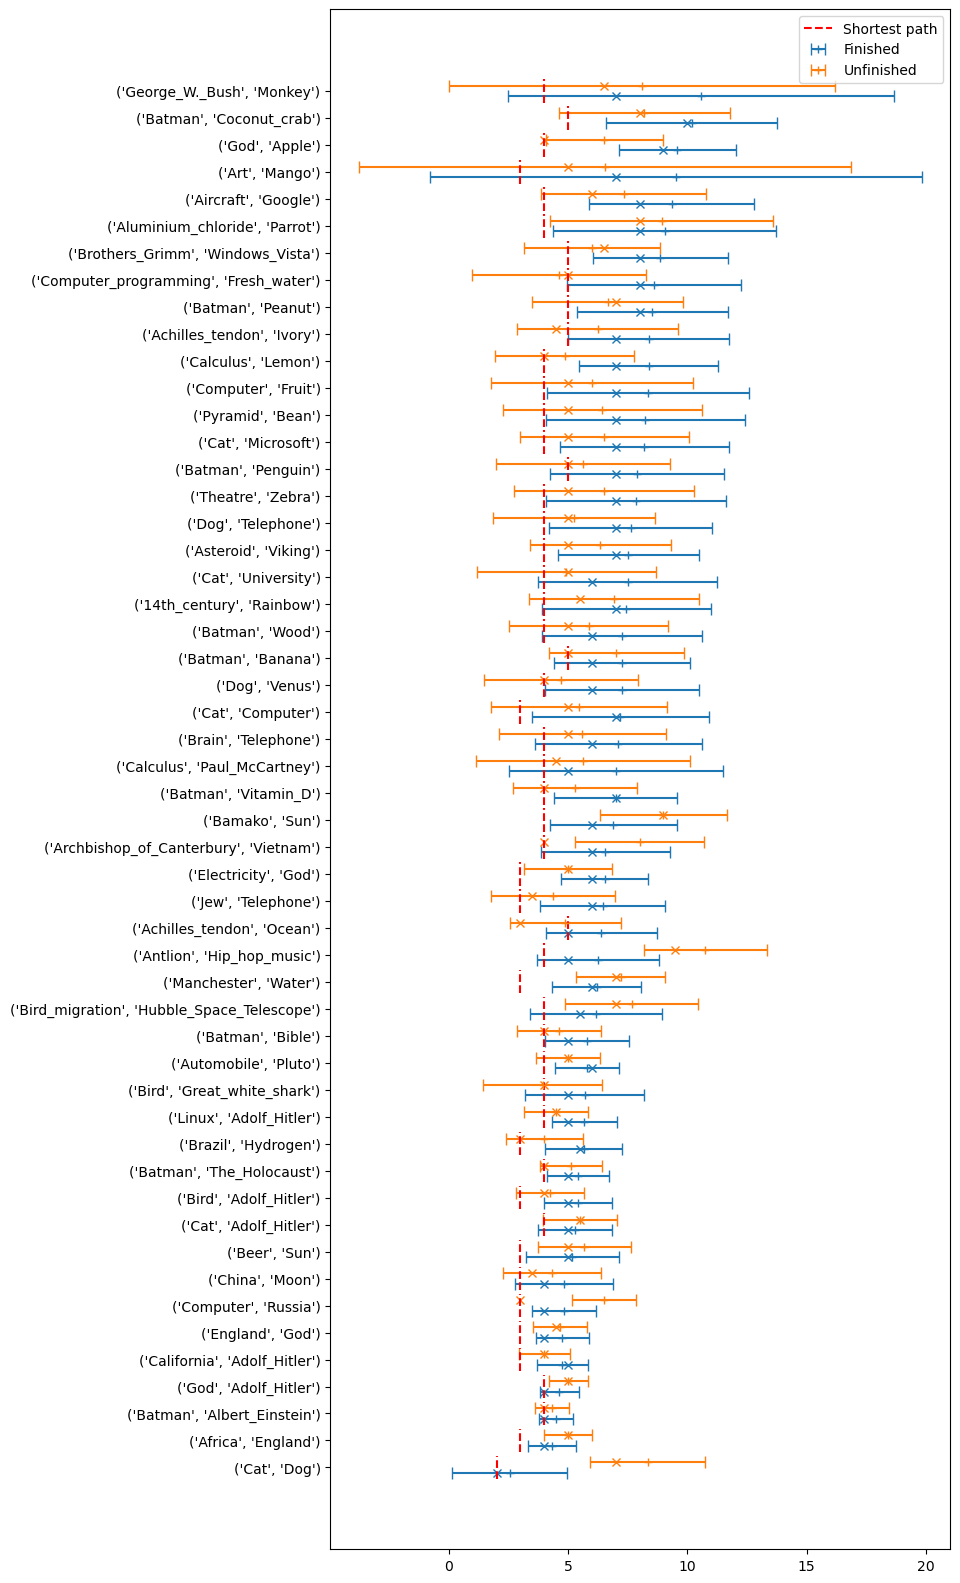

In [56]:
n = len(stats_big_games.index)
y = np.arange(int(n*4), step=4)
plt.figure(figsize=(8,20))
plt.errorbar(stats_big_games['avg_f_path'], y, xerr=stats_big_games['std_f_path']*1.96/2,
             linestyle='', marker='+', capsize=4, label='Finished', color='tab:blue')
plt.plot(stats_big_games['med_f_path'], y, 'x', color='tab:blue')
plt.errorbar(stats_big_games['avg_unf_path'], y+1.5, xerr=stats_big_games['std_f_path']*1.96/2,
             linestyle='', marker='+', capsize=4, label='Unfinished', color='tab:orange')
plt.plot(stats_big_games['med_unf_path'], y+1.5, 'x', color='tab:orange')
for i in range(n):
    if i==1:
        plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+1.5+1], 'r--', label='Shortest path')
    else:
        plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+1.5+1], 'r--')

plt.yticks(y+0.75, stats_big_games.index);
plt.legend();

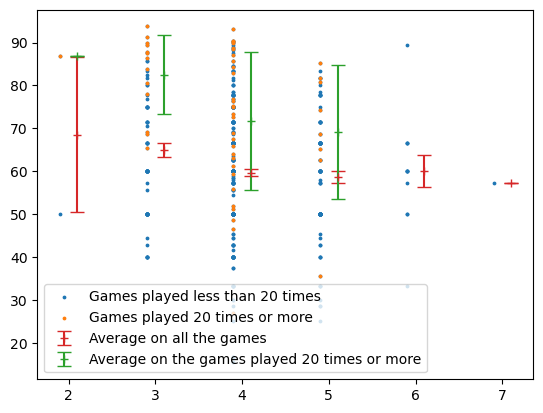

In [ ]:
# np.histogram2d(stats_games['shortest_path'], stats_games['percentage_success'])
# plt.hist2d(stats_games['shortest_path'], stats_games['percentage_success'])
ms=3; cp=5; gap=0.1
plt.scatter(stats_games['shortest_path']-gap, stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['shortest_path']-gap, stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

plt.errorbar(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1)+gap, 
             stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(), 
             yerr=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').sem().fillna(0).values.flatten()*1.96/2, 
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:red', label='Average on all the games')

plt.errorbar(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1)+gap,
             stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(),
             yerr=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').std().fillna(0).values.flatten()*1.96/2,
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:green', label=f'Average on the games played {num_games} times or more')

plt.legend()

In [58]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1).reshape(-1, 1), stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-2.07176277]), 70.78647161959394)

In [59]:
linReg = LinearRegression()
linReg.fit(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1).reshape(-1, 1), stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-6.40688826]), 100.00439389821202)

In [60]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod_all = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games)
mod_all.fit().summary()

mod_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_mean.fit().summary()

mod_big_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_big_mean.fit().summary()


/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     36.13
Date:                Fri, 15 Nov 2024   Prob (F-statistic):             0.0266
Time:                        10:42:34   Log-Likelihood:                -7.7634
No. Observations:                   4   AIC:                             19.53
Df Residuals:                       2   BIC:                             18.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       100.0044      3.916     25.536      0.002      83.154     116.854
shortest_path    -6.4069      1.066     -6.011      0.027     -10.993      -1.821
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.283
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.492
Skew:                          -0.636   Prob(JB):                        0.782
Kurtosis:                       1.844   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

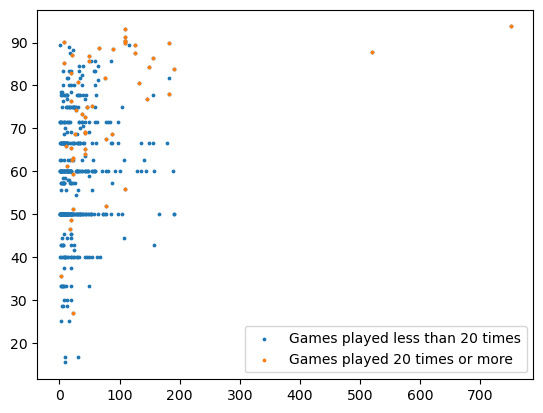

In [61]:
# np.histogram2d(stats_games['links_to_target'], stats_games['percentage_success'])
# plt.hist2d(stats_games['links_to_target'], stats_games['percentage_success'])
ms=3; cp=5; gap=0.1
plt.scatter(stats_games['links_to_target'], stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['links_to_target'], stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

# plt.errorbar(stats_games['links_to_target'].unique()+gap, 
#              stats_games[['percentage_success', 'links_to_target']].groupby('links_to_target').mean().values.flatten(), 
#              yerr=stats_games[['percentage_success', 'links_to_target']].groupby('links_to_target').sem().fillna(0).values.flatten()*1.96/2, 
#              linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:red', label='Average on all the games')

# plt.errorbar(stats_games['links_to_target'].unique()+gap,
            #  stats_big_games[['percentage_success', 'links_to_target']].groupby('links_to_target').mean().values.flatten(),
            #  yerr=stats_big_games[['percentage_success', 'links_to_target']].groupby('links_to_target').std().fillna(0).values.flatten()*1.96/2,
            #  linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:green', label=f'Average on the games played {num_games} or more times')

# plt.xscale('log')
plt.legend()

In [72]:

mod_big = smf.ols(formula='percentage_success ~ log_links_to_target', data=stats_big_games)
mod_big.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     20.20
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           4.14e-05
Time:                        10:43:04   Log-Likelihood:                -206.82
No. Observations:                  52   AIC:                             417.6
Df Residuals:                      50   BIC:                             421.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              44.1571      6.952      6.351      0.000      30.193      58.122
log_links_to_target     7.6982      1.713      4.495      0.000       4.258      11.138
==============================================================================
Omnibus:                        5.634   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                4.928
Skew:                          -0.502   Prob(JB):                       0.0851
Kurtosis:                       4.125   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only win or only loose

In [63]:
# stats_games_win_or_loose = stats_finished.join(stats_unfinished, how='outer', lsuffix='_f', rsuffix='_unf').drop(stats_games.index).rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})
# stats_games_win_or_loose
# stats_big_games_win_or_loose = stats_games_win_or_loose.loc[(stats_games_win_or_loose['finished']>10) | (stats_games_win_or_loose['unfinished']>10)]
# stats_big_games_win_or_loose['success'] = stats_big_games_win_or_loose.finished.isna()
# # stats_big_games_win_or_loose[['finished', 'avg_f_path', 'std_f_path', 'med_f_path']] = stats_big_games_win_or_loose[['finished', 'avg_f_path', 'std_f_path', 'med_f_path']].fillna(stats_big_games_win_or_loose[['unfinished', 'avg_unf_path', 'std_unf_path', 'med_unf_path']])
# stats_big_games_win_or_loose

# Sankey diagram of number of links between categories

In [64]:
categories_cleaned

,category,main_category
article,,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
%C3%85land,[Countries],Countries
%C3%89douard_Manet,"[People, Artists]",People
%C3%89ire,[Countries],Countries
%C3%93engus_I_of_the_Picts,"[History, British_History, British_History_150...",History
...,...,...
Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
Zirconium,"[Science, Chemistry, Chemical_elements]",Science
Zoroaster,"[People, Religious_figures_and_leaders]",People


In [65]:
original_links2007 = pd.read_csv('data/2007/links.tsv',sep='\t', comment='#', names=['linkSource', 'linkTarget'])
articles_names_from_links = list(original_links2007.linkSource.unique()) + list(original_links2007.linkTarget.unique())
articles_names_from_links = list(set(articles_names_from_links))
indices_to_keep = np.where(np.isin(articles_names_from_links, categories_cleaned.index))[0]
articles_to_keep = np.array(articles_names_from_links)[indices_to_keep]
original_links2007 = original_links2007[original_links2007.linkSource.isin(articles_to_keep) & original_links2007.linkTarget.isin(articles_to_keep)]
original_links2007
# original_links2007['catSource'] = original_links2007['linkSource'].map(lambda x: categories_cleaned.main_cat.loc[x])

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


In [66]:
indices_to_drop = np.where(~np.isin(articles_names_from_links, categories_cleaned.index))[0]
articles_to_drop = np.array(articles_names_from_links)[indices_to_drop]
articles_to_drop

array(['Pikachu', 'Friend_Directdebit', 'Sponsorship_Directdebit',
       'Directdebit'], dtype='<U83')

In [67]:

original_links2007['catSource'] = original_links2007['linkSource'].map(lambda x: categories_cleaned.main_category.loc[x])
original_links2007['catTarget'] = original_links2007['linkTarget'].map(lambda x: categories_cleaned.main_category.loc[x])

In [68]:
original_links2007

,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


In [69]:

def get_sankey_data_links(df, filename='sankey_data_links.csv', categories=categories_cleaned):

    grouped_by_cat = df.groupby(['catSource', 'catTarget'])#.apply(lambda x: x).drop(columns=['source_cat', 'target_cat']).sort_index()
    # grouped_by_cat

    cat = list(categories.category.apply(lambda x: x[0]).value_counts().sort_index().index)

    # main_cat
    source = []
    target = []
    value = []
    for (scat, ecat), group in grouped_by_cat:
        source.append(scat)
        target.append(ecat)
        value.append(len(group))
    sankey_data_finished = pd.DataFrame(zip(source, target, value), columns=['source', 'target', 'val'])
    sankey_data_finished.to_csv('./data/sankey/'+filename, index=False)
    return np.array(value)/sum(value), sum(value)

val_links, num_links = get_sankey_data_links(original_links2007)
val_links, num_links

# https://public.flourish.studio/visualisation/20287849/

(array([1.05119135e-03, 5.00567310e-05, 2.16912501e-04, 1.15130481e-03,
        2.50283655e-04, 2.16912501e-04, 9.09363946e-04, 1.24307549e-03,
        1.66855770e-05, 4.33825002e-04, 2.50283655e-05, 1.08456250e-04,
        1.62684376e-03, 5.00567310e-04, 5.42281252e-04, 2.50283655e-05,
        2.89494761e-03, 1.40993126e-03, 6.97457118e-03, 5.25595675e-04,
        6.25709137e-04, 3.07848895e-03, 1.17633318e-03, 2.58626443e-04,
        2.75312020e-04, 1.08456250e-04, 8.34278849e-06, 7.67536541e-04,
        1.91884135e-04, 1.40993126e-03, 2.08569712e-04, 1.46833077e-03,
        9.17706734e-03, 1.66021491e-02, 6.59080291e-04, 1.27644664e-03,
        6.74097310e-03, 6.05686445e-03, 3.83768271e-04, 1.65187212e-03,
        3.00340386e-04, 1.25141827e-04, 4.37996396e-03, 2.06066876e-03,
        2.34432357e-03, 3.17025963e-04, 4.55516252e-03, 9.63592071e-03,
        4.60772209e-02, 8.00907695e-04, 4.55516252e-03, 1.98892078e-02,
        9.31889475e-03, 1.50170193e-04, 4.71367550e-03, 1.251418

# Ideas
- compare number of links per page VS success rate
- shortest path VS success rate